In [1]:
import importlib
import numpy as np
import matplotlib.pyplot as plt
import torch

# Reload uamocf submodules to pick up any changes
import uamocf.models
import uamocf.visualization
importlib.reload(uamocf.models)
importlib.reload(uamocf.visualization)
import uamocf
importlib.reload(uamocf)

# Import from uamocf package
from uamocf import (
    # Data generation
    DataConfig,
    sample_dataset,
    
    # Models
    SimpleNN,
    EnsembleModel,
    
    # Training
    TrainConfig,
    train_ensemble,
    
    # Counterfactual problem
    CFConfig,
    make_cf_problem,
    
    # Optimization
    NSGAConfig,
    run_nsga2,
    
    # Uncertainty
    compute_uncertainty_decomposition,
    
    # Visualization
    plot_proba,
    plot_uncertainty_heatmap,
    plot_pareto_front_2d,
)

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 1. Generate Multi-Class Dataset

We generate a 2D dataset with **3 classes** using the boundary-focused probability surface.
This creates interesting overlapping regions where the classifier must distinguish between multiple classes.

In [2]:
# Configure multi-class data generation
N_CLASSES = 3

data_config = DataConfig(
    n=1500,              # Number of samples
    d=2,                 # 2D feature space
    n_classes=N_CLASSES, # Multi-class!
    p_fn_name="moon",  # Use moons distribution
    seed=42,
)

# Generate data
X, y, probs = sample_dataset(data_config)

print(f"Generated {len(X)} samples with {N_CLASSES} classes")
print(f"Class distribution: {np.bincount(y)}")
print(f"Feature ranges: X1=[{X[:,0].min():.2f}, {X[:,0].max():.2f}], X2=[{X[:,1].min():.2f}, {X[:,1].max():.2f}]")

Generated 1500 samples with 3 classes
Class distribution: [620 629 251]
Feature ranges: X1=[-1.00, 1.00], X2=[-1.00, 1.00]


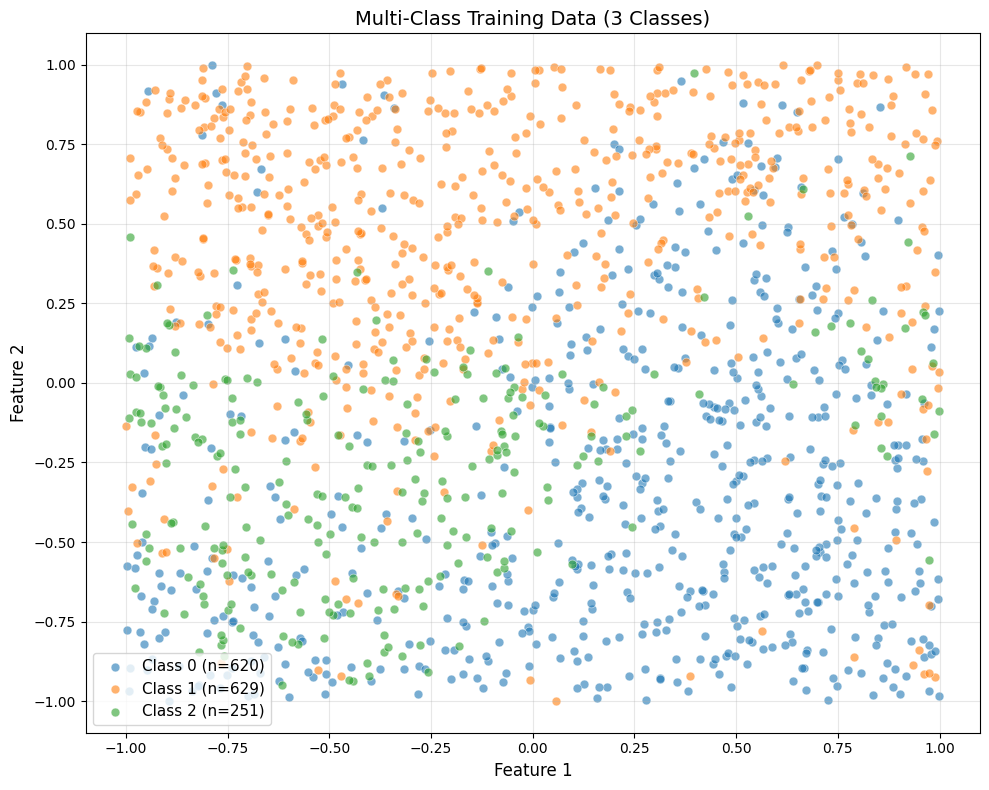

In [3]:
# Visualize the multi-class dataset
fig, ax = plt.subplots(figsize=(10, 8))

# Use distinct colors for each class
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # blue, orange, green
for c in range(N_CLASSES):
    mask = y == c
    ax.scatter(X[mask, 0], X[mask, 1], c=colors[c], 
               alpha=0.6, edgecolors='white', linewidth=0.5,
               label=f'Class {c} (n={np.sum(mask)})', s=40)

ax.set_xlabel('Feature 1', fontsize=12)
ax.set_ylabel('Feature 2', fontsize=12)
ax.set_title('Multi-Class Training Data (3 Classes)', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 2. Train Multi-Class Ensemble

Train an ensemble of 5 neural networks with **3 output classes**.

In [4]:
# Configure training
train_config = TrainConfig(
    epochs=50,
    lr=0.01,
    batch_size=32,
    seed=42,
)

# Train ensemble of 5 models with 3 output classes
print("Training multi-class ensemble...")
train_results = train_ensemble(
    num_models=5,
    X=X,
    y=y,
    cfg=train_config,
    model_factory=lambda: SimpleNN(input_dim=2, hidden_dim=64, output_dim=N_CLASSES),
)

# Create ensemble from trained models
ensemble = EnsembleModel([r.model for r in train_results])

print(f"\n✓ Ensemble trained with {len(ensemble.models)} models")
print(f"  Output classes: {N_CLASSES}")
print(f"  Average validation accuracy: {np.mean([r.val_accuracy for r in train_results]):.2%}")

Training multi-class ensemble...

--- Training Model 1/5 ---


Training: 100%|███████████| 50/50 [00:04<00:00, 10.14epoch/s, Train Loss=0.5769]



  Val Accuracy: 70.67%

--- Training Model 2/5 ---


Training: 100%|███████████| 50/50 [00:05<00:00,  9.27epoch/s, Train Loss=0.5769]


  Val Accuracy: 72.00%

--- Training Model 3/5 ---


Training: 100%|███████████| 50/50 [00:05<00:00,  9.86epoch/s, Train Loss=0.6227]


  Val Accuracy: 77.67%

--- Training Model 4/5 ---


Training: 100%|███████████| 50/50 [00:05<00:00,  9.92epoch/s, Train Loss=0.5957]


  Val Accuracy: 74.33%

--- Training Model 5/5 ---


Training: 100%|███████████| 50/50 [00:05<00:00,  9.66epoch/s, Train Loss=0.5925]

  Val Accuracy: 74.33%

✓ Ensemble trained with 5 models
  Output classes: 3
  Average validation accuracy: 73.80%


## 3. Visualize Multi-Class Decision Boundaries

For multi-class problems, we can visualize:
1. **Decision regions**: Which class is predicted for each point
2. **Per-class probability surfaces**: P(class k | x) for each class k

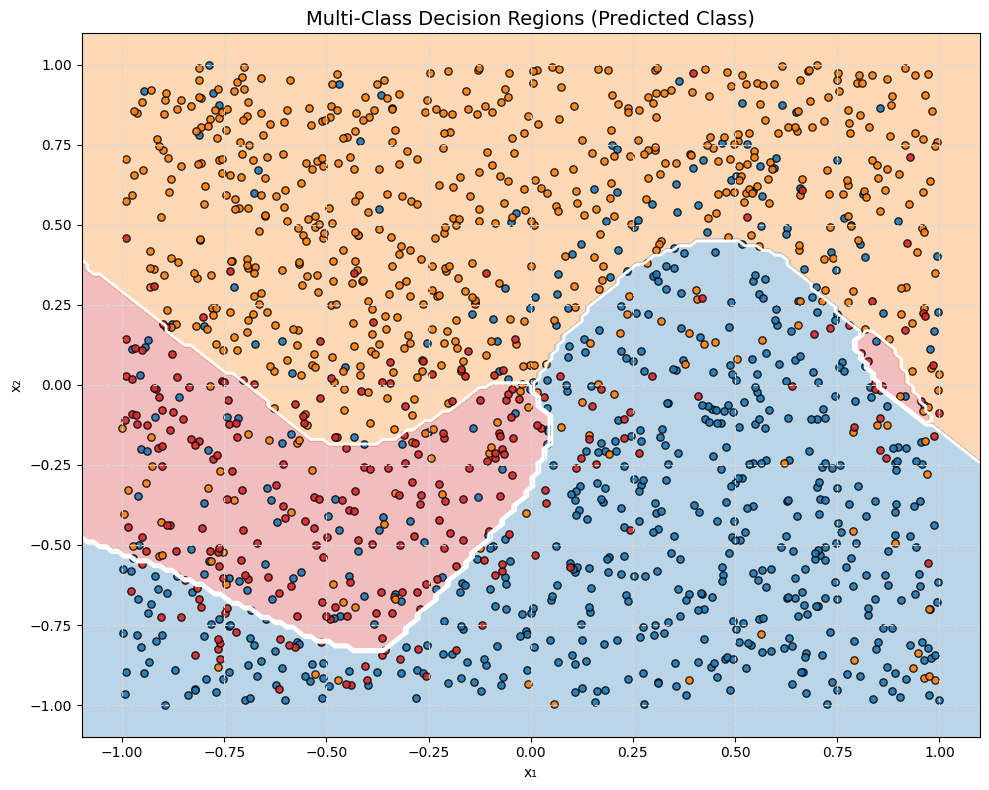

In [5]:
# Plot decision regions (max-class coloring)
fig, ax = plt.subplots(figsize=(10, 8))
plot_proba(ensemble, X, y, class_of_interest=None, grid_resolution=150, ax=ax, device=device)
ax.set_title('Multi-Class Decision Regions (Predicted Class)', fontsize=14)
plt.tight_layout()
plt.show()

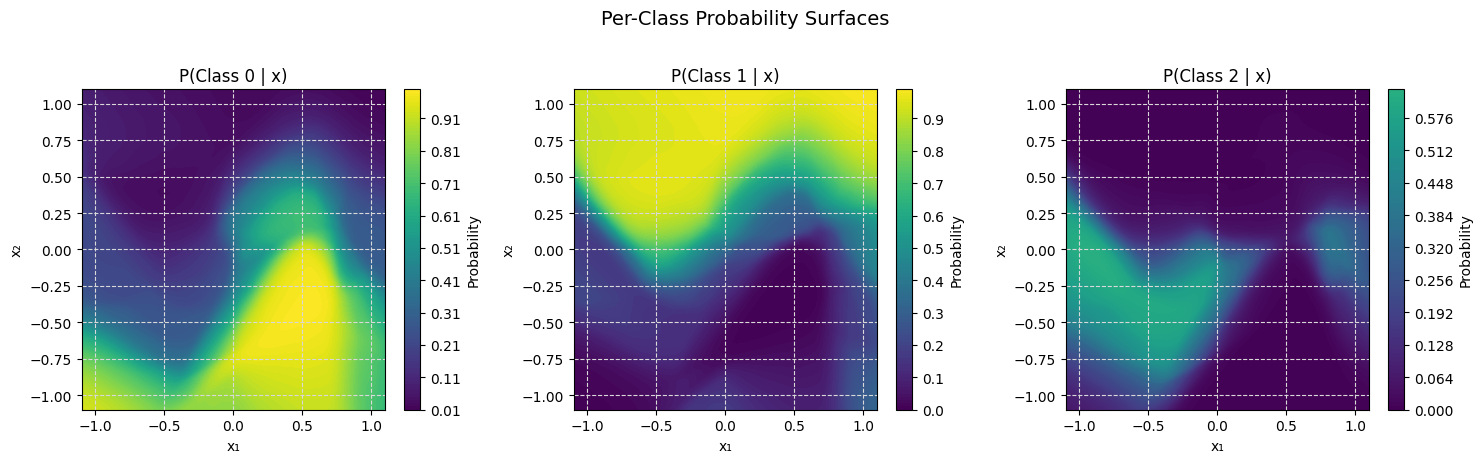

In [6]:
# Plot probability surface for each class
fig, axes = plt.subplots(1, N_CLASSES, figsize=(5 * N_CLASSES, 4.5))

for k in range(N_CLASSES):
    plot_proba(ensemble, X, class_of_interest=k, grid_resolution=100, ax=axes[k], device=device)
    axes[k].set_title(f'P(Class {k} | x)', fontsize=12)

plt.suptitle('Per-Class Probability Surfaces', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

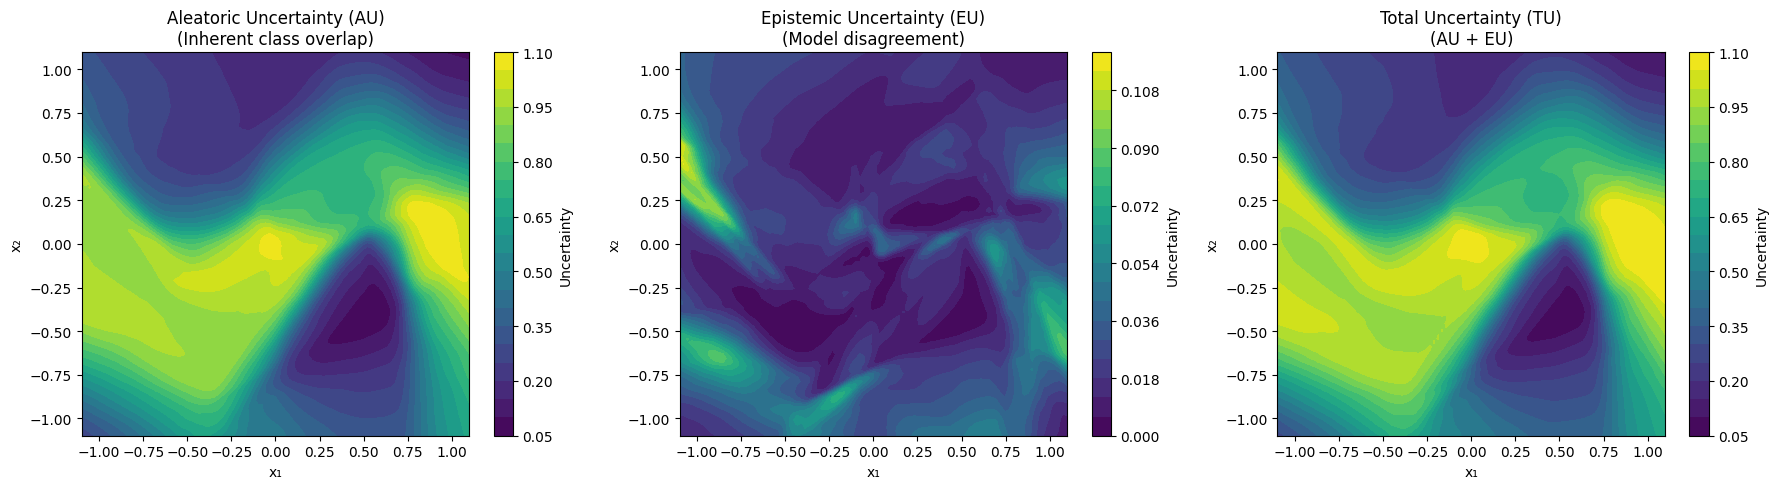

In [7]:
# Plot uncertainty heatmaps
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

plot_uncertainty_heatmap(
    ensemble.models, X, device=device,
    uncertainty_type='aleatoric', ax=axes[0]
)
axes[0].set_title('Aleatoric Uncertainty (AU)\n(Inherent class overlap)')

plot_uncertainty_heatmap(
    ensemble.models, X, device=device,
    uncertainty_type='epistemic', ax=axes[1]
)
axes[1].set_title('Epistemic Uncertainty (EU)\n(Model disagreement)')

plot_uncertainty_heatmap(
    ensemble.models, X, device=device,
    uncertainty_type='total', ax=axes[2]
)
axes[2].set_title('Total Uncertainty (TU)\n(AU + EU)')

plt.tight_layout()
plt.show()

## 4. Select a Factual Instance

Choose a point from **class 0** that we want to flip to a different class.
In multi-class scenarios, we can choose **any** target class (not just one).

In [8]:
# Select a factual point from class 0
class_0_indices = np.where(y == 0)[0]
factual_idx = class_0_indices[15]  # Pick one point
factual = X[factual_idx]

# Get model prediction for the factual
factual_t = torch.from_numpy(factual.astype(np.float32)).unsqueeze(0).to(device)
with torch.no_grad():
    probs_factual = ensemble.predict_proba(factual_t)
    pred_class = probs_factual.argmax(dim=1).item()

# Compute uncertainty at factual point
unc = compute_uncertainty_decomposition(ensemble.models, factual, device)

print(f"Factual point: [{factual[0]:.4f}, {factual[1]:.4f}]")
print(f"True class: {y[factual_idx]}")
print(f"Predicted class: {pred_class}")
print(f"\nClass probabilities:")
for k in range(N_CLASSES):
    print(f"  P(class={k}): {probs_factual[0, k]:.4f}")
print(f"\nUncertainty at factual:")
print(f"  Aleatoric (AU): {unc.aleatoric:.4f}")
print(f"  Epistemic (EU): {unc.epistemic:.4f}")
print(f"  Total (TU):     {unc.total:.4f}")

Factual point: [0.2694, 0.1072]
True class: 0
Predicted class: 0

Class probabilities:
  P(class=0): 0.6433
  P(class=1): 0.2970
  P(class=2): 0.0597

Uncertainty at factual:
  Aleatoric (AU): 0.8145
  Epistemic (EU): 0.0050
  Total (TU):     0.8195


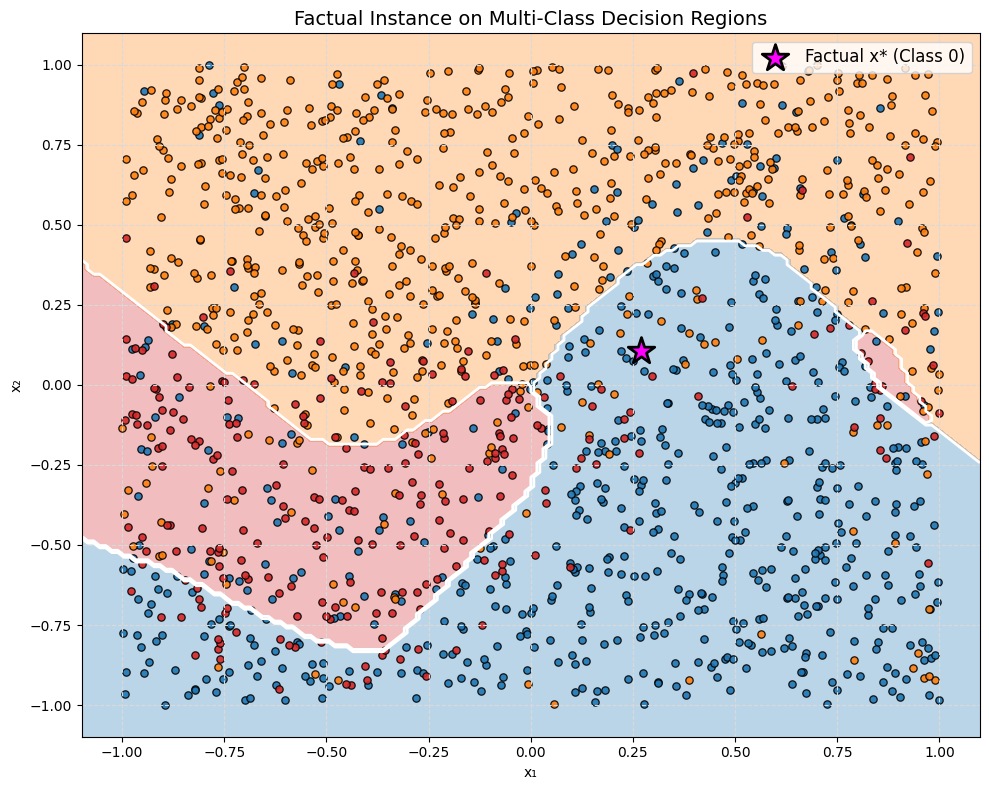

In [9]:
# Visualize the factual point on the decision regions
fig, ax = plt.subplots(figsize=(10, 8))

# Plot decision regions as background
plot_proba(ensemble, X, y, class_of_interest=None, grid_resolution=150, ax=ax, device=device)

# Highlight factual point
ax.scatter(factual[0], factual[1], c='magenta', s=400, marker='*', 
           edgecolors='black', linewidth=2, label=f'Factual x* (Class {y[factual_idx]})', zorder=10)

ax.set_title('Factual Instance on Multi-Class Decision Regions', fontsize=14)
ax.legend(fontsize=12, loc='upper right')
plt.tight_layout()
plt.show()

## 5. Generate Counterfactuals to Different Target Classes

In multi-class scenarios, we can generate counterfactuals to **different target classes**.
Let's generate CFs for flipping from class 0 → class 1, and class 0 → class 2.

In [10]:
# Configure counterfactual generation
# Note: AU is maximized, EU is minimized (prefer confident regions)
cf_config = CFConfig()

nsga_config = NSGAConfig(
    pop_size=100,
    n_gen=50,
    verbose=True,
)

# Store results for each target class
cf_results = {}

factual_t = torch.from_numpy(factual.astype(np.float32)).to(device)
X_t = torch.from_numpy(X.astype(np.float32)).to(device)

# Generate CFs for each target class (except the factual's class)
for target_class in range(N_CLASSES):
    if target_class == y[factual_idx]:
        continue  # Skip the factual's own class
    
    print(f"\n{'='*60}")
    print(f"Generating counterfactuals for target class {target_class}")
    print(f"{'='*60}")
    
    target_t = torch.tensor([target_class], device=device)
    
    problem = make_cf_problem(
        model=ensemble.models[0],
        x_star=factual_t,
        y_target=target_t,
        X_obs=X_t,
        config=cf_config,
        ensemble=ensemble.models,
        device=device,
    )
    
    result = run_nsga2(problem=problem, config=nsga_config)
    cf_results[target_class] = (problem, result)
    
    # Count valid CFs
    if result.F is not None:
        validity = result.F[:, 0]
        n_valid = np.sum(validity < 0.5)
        print(f"\n✓ Found {len(result.X)} CFs, {n_valid} valid (P(target) > 0.5)")


Generating counterfactuals for target class 1
Gen    1 | Valid CFs (pop):  46 | Valid CFs (archive):  26 | Best P(target): 0.978 | Mean Sparsity: 1.906
Gen   10 | Valid CFs (pop):  81 | Valid CFs (archive):  81 | Best P(target): 0.993 | Mean Sparsity: 1.840
Gen   20 | Valid CFs (pop):  78 | Valid CFs (archive):  78 | Best P(target): 0.994 | Mean Sparsity: 1.790
Gen   30 | Valid CFs (pop):  77 | Valid CFs (archive):  77 | Best P(target): 0.994 | Mean Sparsity: 1.800
Gen   40 | Valid CFs (pop):  74 | Valid CFs (archive):  74 | Best P(target): 0.995 | Mean Sparsity: 1.840
Gen   50 | Valid CFs (pop):  78 | Valid CFs (archive):  78 | Best P(target): 0.995 | Mean Sparsity: 1.840

✓ Found 100 CFs, 78 valid (P(target) > 0.5)

Generating counterfactuals for target class 2
Gen    1 | Valid CFs (pop):  10 | Valid CFs (archive):   8 | Best P(target): 0.755 | Mean Sparsity: 1.727
Gen   10 | Valid CFs (pop):  71 | Valid CFs (archive):  71 | Best P(target): 0.791 | Mean Sparsity: 1.710
Gen   20 | Va

## 6. Visualize Counterfactuals for Each Target Class

Compare counterfactuals generated for different target classes.

In [11]:
# 3D Pareto Front Visualization for Each Target Class
import plotly.graph_objects as go
from plotly.subplots import make_subplots

target_classes = [k for k in cf_results.keys()]

for target_class in target_classes:
    problem, result = cf_results[target_class]

    if result.F is None or len(result.F) == 0:
        continue
    
    # Separate valid and invalid
    # Objectives: [0] Validity (1-P), [1] Sparsity, [2] AU (negated), [3] EU (positive)
    validity = result.F[:, 0]
    valid_mask = validity < 0.5
    invalid_mask = ~valid_mask
    
    valid_F = result.F[valid_mask]
    invalid_F = result.F[invalid_mask]
    
    # Evaluate factual in objective space
    F_factual = problem.evaluate(factual.astype(np.float32))
    F_X = problem.evaluate(X)
    
    fig = go.Figure()
    
    # Original observations in Obj Space (for context)
    # Use EU (index 3, positive) for x, Validity (index 0) for y, AU (index 2, negated) for z
    fig.add_trace(go.Scatter3d(
        x=F_X[:, 3], y=F_X[:, 0], z=-F_X[:, 2],  # EU is positive, negate AU
        mode='markers',
        marker=dict(color='green', size=3, opacity=0.2),
        name='Original observations in Obj Space'
    ))
    
    # Invalid CFs (blue)
    if len(invalid_F) > 0:
        fig.add_trace(go.Scatter3d(
            x=invalid_F[:, 3], y=invalid_F[:, 0], z=-invalid_F[:, 2],
            mode='markers',
            marker=dict(color='blue', size=4, opacity=0.6, symbol='cross'),
            name=f'Invalid CFs (n={len(invalid_F)})'
        ))
    
    # Valid CFs (red)
    if len(valid_F) > 0:
        fig.add_trace(go.Scatter3d(
            x=valid_F[:, 3], y=valid_F[:, 0], z=-valid_F[:, 2],
            mode='markers',
            marker=dict(color='red', size=5, symbol='cross'),
            name=f'Valid CFs (n={len(valid_F)})'
        ))
    
    # Factual (purple)
    fig.add_trace(go.Scatter3d(
        x=[F_factual[3]], y=[F_factual[0]], z=[-F_factual[2]],
        mode='markers',
        marker=dict(color='purple', size=8),
        name='Factual x*'
    ))
    
    fig.update_layout(
        scene=dict(
            xaxis_title='Epistemic Uncertainty (minimize)',
            yaxis_title='Invalidity (1-P(target))',
            zaxis_title='Aleatoric Uncertainty (maximize)',
        ),
        width=800, height=600,
        title=f'Pareto Front: Class {y[factual_idx]} → Class {target_class}'
    )
    
    fig.show()

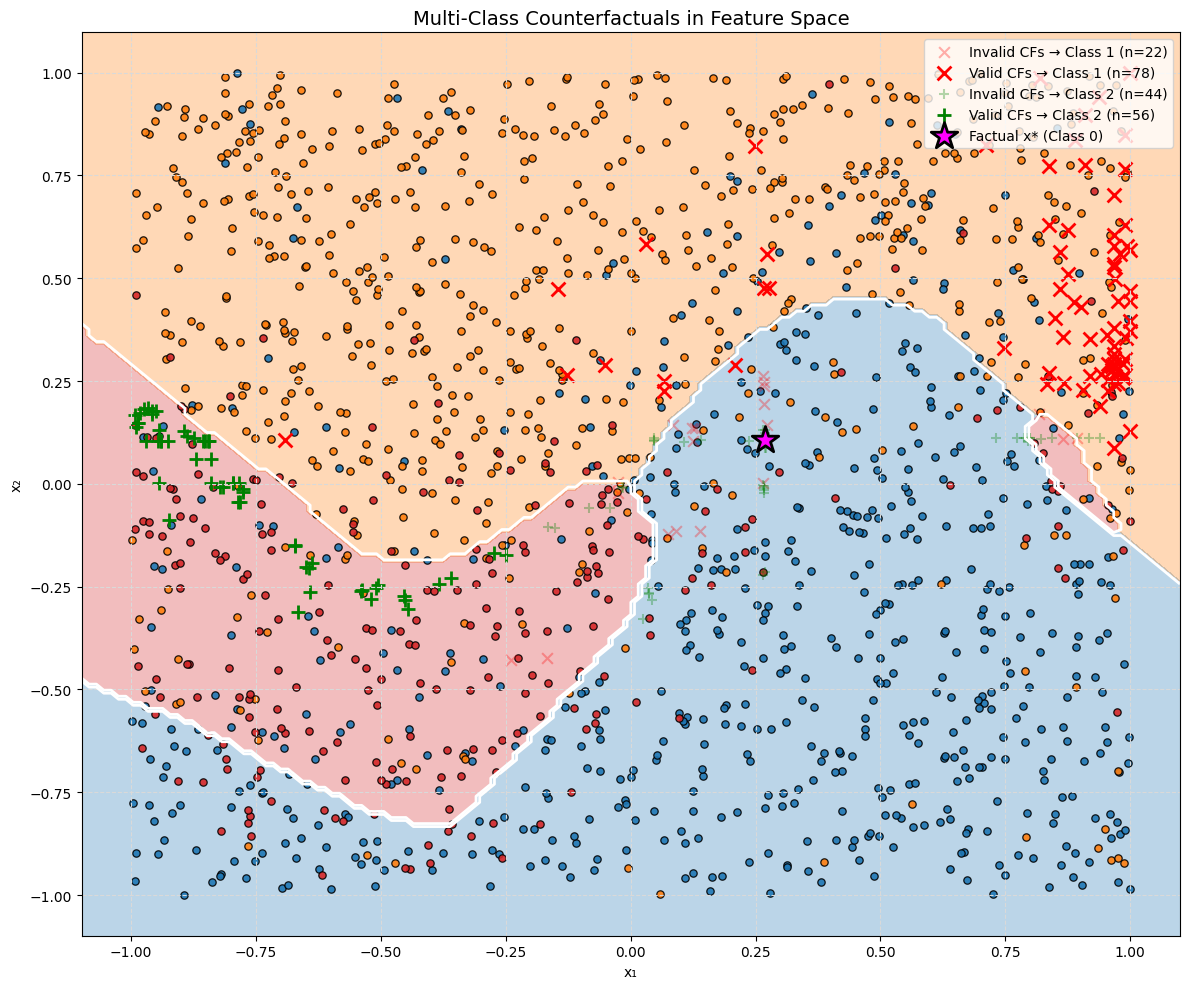

In [12]:
# Feature Space: All counterfactuals overlaid on decision regions
fig, ax = plt.subplots(figsize=(12, 10))

# Plot decision regions as background
plot_proba(ensemble, X, y, class_of_interest=None, grid_resolution=150, ax=ax, device=device)

# Color map for target classes
cf_colors = {1: 'red', 2: 'green'}  # Different color for each target
cf_markers = {1: 'x', 2: '+'}

for target_class in target_classes:
    problem, result = cf_results[target_class]
    
    if result.F is None or len(result.F) == 0:
        continue
    
    # Get valid CFs
    validity = result.F[:, 0]
    valid_mask = validity < 0.5
    valid_cfs = result.X[valid_mask]
    invalid_cfs = result.X[~valid_mask]
    
    color = cf_colors.get(target_class, 'cyan')
    marker = cf_markers.get(target_class, 'x')
    
    # Plot invalid CFs (lighter)
    if len(invalid_cfs) > 0:
        ax.scatter(invalid_cfs[:, 0], invalid_cfs[:, 1],
                   c=color, s=60, marker=marker, alpha=0.3, linewidths=1.5,
                   label=f'Invalid CFs → Class {target_class} (n={len(invalid_cfs)})')
    
    # Plot valid CFs (solid)
    if len(valid_cfs) > 0:
        ax.scatter(valid_cfs[:, 0], valid_cfs[:, 1],
                   c=color, s=100, marker=marker, linewidths=2,
                   label=f'Valid CFs → Class {target_class} (n={len(valid_cfs)})')

# Factual point
ax.scatter(factual[0], factual[1], c='magenta', s=400, marker='*',
           edgecolors='black', linewidth=2, label=f'Factual x* (Class {y[factual_idx]})', zorder=10)

ax.set_title('Multi-Class Counterfactuals in Feature Space', fontsize=14)
ax.legend(fontsize=10, loc='upper right')
plt.tight_layout()
plt.show()

## 7. Compare Counterfactuals Across Target Classes

Analyze the properties of counterfactuals for different target classes.

In [13]:
print("Comparison of Counterfactuals Across Target Classes")
print("=" * 70)

obj_names = ['Invalidity (1-P)', 'Epistemic U.', 'Sparsity', 'Aleatoric U.']

for target_class in target_classes:
    problem, result = cf_results[target_class]
    
    if result.F is None or len(result.F) == 0:
        continue
    
    validity = result.F[:, 0]
    valid_mask = validity < 0.5
    n_valid = np.sum(valid_mask)
    n_invalid = len(result.X) - n_valid
    
    print(f"\nTarget Class {target_class} (from Class {y[factual_idx]}):")
    print(f"  Total CFs: {len(result.X)}")
    print(f"  Valid: {n_valid}, Invalid: {n_invalid}")
    
    if n_valid > 0:
        valid_F = result.F[valid_mask]
        valid_X = result.X[valid_mask]
        
        # Best valid CF (lowest invalidity)
        best_idx = np.argmin(valid_F[:, 0])
        best_cf = valid_X[best_idx]
        
        # Distance to factual
        distances = np.linalg.norm(valid_X - factual, axis=1)
        
        print(f"  \n  Valid CF Statistics:")
        print(f"    Avg distance from factual: {distances.mean():.4f}")
        print(f"    Min distance: {distances.min():.4f}")
        print(f"    Best validity (1-P): {valid_F[best_idx, 0]:.4f}")
        print(f"    Best CF location: [{best_cf[0]:.3f}, {best_cf[1]:.3f}]")

Comparison of Counterfactuals Across Target Classes

Target Class 1 (from Class 0):
  Total CFs: 100
  Valid: 78, Invalid: 22
  
  Valid CF Statistics:
    Avg distance from factual: 0.7254
    Min distance: 0.1907
    Best validity (1-P): 0.0054
    Best CF location: [0.999, 0.998]

Target Class 2 (from Class 0):
  Total CFs: 100
  Valid: 56, Invalid: 44
  
  Valid CF Statistics:
    Avg distance from factual: 1.0610
    Min distance: 0.5894
    Best validity (1-P): 0.2089
    Best CF location: [-0.870, 0.060]


In [ ]:
# Sample diverse CFs from each target class
print("\nSample Counterfactuals from Each Target Class")
print("=" * 70)

for target_class in target_classes:
    problem, result = cf_results[target_class]
    
    if result.F is None or len(result.F) == 0:
        continue
    
    validity = result.F[:, 0]
    valid_mask = validity < 0.5
    
    if np.sum(valid_mask) == 0:
        print(f"\nTarget Class {target_class}: No valid CFs found")
        continue
    
    valid_X = result.X[valid_mask]
    valid_F = result.F[valid_mask]
    
    print(f"\n--- Target Class {target_class} ---")
    
    # Show top 3 CFs by validity
    sorted_idx = np.argsort(valid_F[:, 0])[:3]
    
    for i, idx in enumerate(sorted_idx):
        cf = valid_X[idx]
        cf_t = torch.from_numpy(cf.astype(np.float32)).unsqueeze(0).to(device)
        
        with torch.no_grad():
            probs_cf = ensemble.predict_proba(cf_t)
        
        unc_cf = compute_uncertainty_decomposition(ensemble.models, cf, device)
        dist = np.linalg.norm(cf - factual)
        
        print(f"\n  CF #{i+1} [{cf[0]:.3f}, {cf[1]:.3f}]")
        print(f"    P(target={target_class}): {probs_cf[0, target_class]:.4f}")
        print(f"    Distance from factual: {dist:.4f}")
        print(f"    AU: {unc_cf.aleatoric:.4f}, EU: {unc_cf.epistemic:.4f}")


Sample Counterfactuals from Each Target Class

--- Target Class 1 ---

  CF #1 [0.999, 0.998]
    P(target=1): 0.9806
    Distance from factual: 1.1518
    AU: 0.1289, EU: 0.0098

  CF #2 [0.938, 0.940]
    P(target=1): 0.9712
    Distance from factual: 1.0676
    AU: 0.1657, EU: 0.0107

  CF #3 [0.819, 0.987]
    P(target=1): 0.9656
    Distance from factual: 1.0374
    AU: 0.1815, EU: 0.0095

--- Target Class 2 ---

  CF #1 [-0.870, 0.060]
    P(target=2): 0.5866
    Distance from factual: 1.1402
    AU: 0.9169, EU: 0.0626

  CF #2 [-0.958, 0.170]
    P(target=2): 0.5508
    Distance from factual: 1.2292
    AU: 0.9261, EU: 0.0809

  CF #3 [-0.974, 0.183]
    P(target=2): 0.5503
    Distance from factual: 1.2458
    AU: 0.9272, EU: 0.0809


: 

## Summary

This demo showed how to:

1. **Generate multi-class data** (3 classes in 2D feature space)
2. **Train a multi-class ensemble** with 3 output classes
3. **Visualize decision regions** showing which class is predicted in each region
4. **Generate counterfactuals to different target classes** - exploring paths from class 0 to class 1, and class 0 to class 2
5. **Compare counterfactuals** across target classes to understand the different paths available

### Key Insights for Multi-Class CFs

- **Multiple target options**: Unlike binary classification, users can choose which class to flip to
- **Different difficulty levels**: Some class transitions may require larger changes than others
- **Boundary proximity**: Valid CFs tend to cluster near decision boundaries between the factual's class and the target class
- **Trade-offs persist**: Even with multiple targets, the Pareto front shows non-dominated solutions with trade-offs between validity, uncertainty, and distance